In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead


In [2]:

model = InceptionV3(weights='imagenet')

model.summary()

96116736/96112376 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [3]:
import tensorflow as tf
import keras
from keras import layers

In [20]:
def build_cnn_model4(LR=0.1,Frame_size=150):
    
    input1 = layers.Input(shape = (299,299,3))
    x1 = layers.Conv2D(filters = 27,kernel_size=(3,3),padding='same', activation='relu')(input1)
    x1 = layers.Conv2D(filters = 45,kernel_size=(3,3),padding='same', activation='relu')(x1)
    
    x11 = layers.GlobalMaxPooling2D()( x1)
    merged = x11
    #input3 = layers.Input(shape=(1))
    #next_zero = layers.Dropout(0.5)(merged)
#     next_one = layers.Dense(270, activation='relu')(merged)
    #next_one = layers.Dense(270, activation='relu')(next_zero)

    #next_two = layers.Dropout(0.5)(next_one)
    next_three = layers.Dense(180, activation='relu')(merged)
    #next_three_con = layers.Concatenate()([next_three, input3])
    #next_four = layers.Dropout(0.5)(next_three_con)
    next_four = layers.Dropout(0.4)(next_three)
    
    next_four = layers.Dense(30, activation = 'relu')(next_four)
    next_four = layers.Dropout(0.4)(next_four)

    next_five = layers.Dense(2, activation='softmax')(next_four)

    # from keras.models import Model
    model = tf.keras.Model(inputs = input1, outputs = next_five)
   # model = tfmot.quantization.keras.quantize_model(model)
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer = optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

mods = build_cnn_model4()
mods.summary()
#tf.keras.utils.plot_model(mods, to_file = 'Model8.png', show_shapes = True)#, to_file='model_combined.png')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 299, 299, 27)      756       
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 299, 299, 45)      10980     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 45)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 180)               8280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

In [21]:
a = (np.vstack((np.zeros(500), np.ones(500))))
a = a.flatten()
np.random.shuffle(a)
a
feats = np.random.rand(1000,299,299,3)
#feats

mods.fit(feats,a)

32/32 [==============================] - 9s 274ms/step - loss: 0.6962 - accuracy: 0.4970


In [22]:
feats.shape

(1000, 299, 299, 3)

In [23]:
!wget https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
!wget https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2020-09-18 04:08:00--  https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
Resolving indiasendangered.com (indiasendangered.com)... 199.79.62.149
Connecting to indiasendangered.com (indiasendangered.com)|199.79.62.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242 (134K) [image/jpeg]
Saving to: ‘elephant.jpg.2’

elephant.jpg.2      100%[===================>] 134.03K   364KB/s    in 0.4s    

2020-09-18 04:08:01 (364 KB/s) - ‘elephant.jpg.2’ saved [137242/137242]

--2020-09-18 04:08:01--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.237.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.237.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25761 (25K) [image/jpeg]
Saving to: ‘Chinook-On-White-03.jpg.2’

Chinook-On-White-03 100%[===================>]  25.16K  --.-KB/s    in 0.08s   


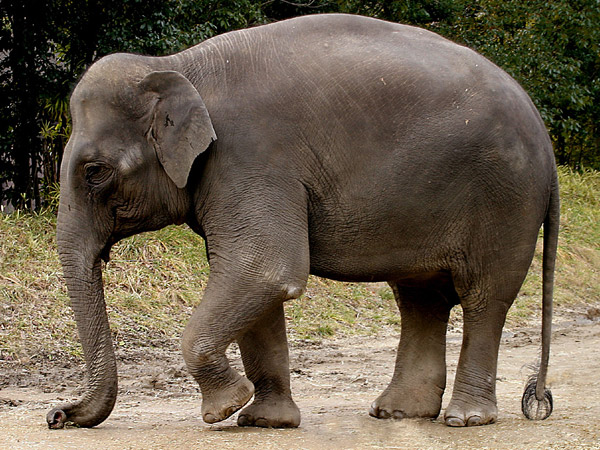

In [24]:
ORIGINAL = 'elephant.jpg'

DIM = 299

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(ORIGINAL)) # Visualize image

In [25]:
model = mods
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)
preds = model.predict(x)
#print(decode_predictions(preds))
preds

(1, 299, 299, 3)


array([[0.47523588, 0.5247641 ]], dtype=float32)

In [26]:
preds.shape

(1, 2)

In [38]:

with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_94')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

In [43]:
np.maximum(heatmap, 0).shape

(1, 299, 299)

In [37]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8, 8))
plt.matshow(heatmap)
plt.show()

ValueError: ignored

In [9]:
img = cv2.imread(ORIGINAL)


In [10]:

INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

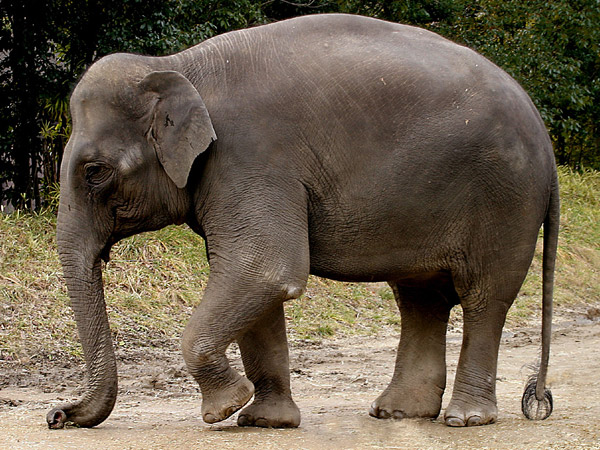

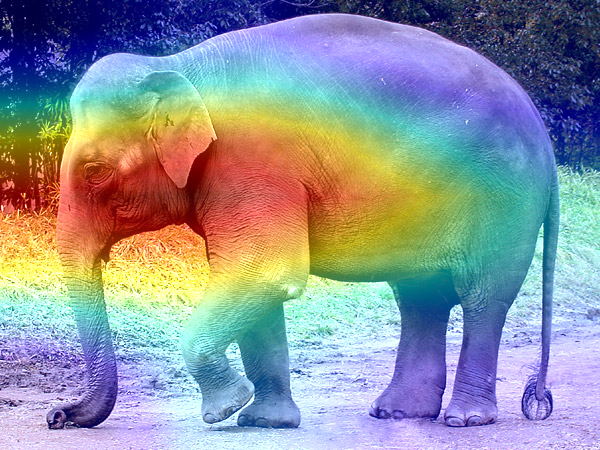

In [11]:
cv2_imshow(cv2.imread(ORIGINAL))
cv2_imshow(img)

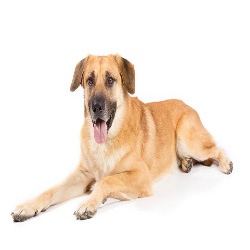

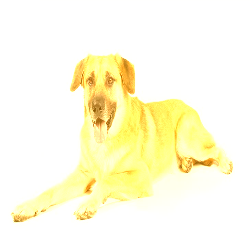

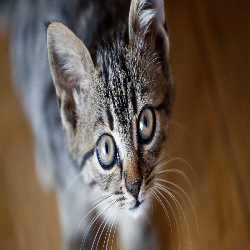

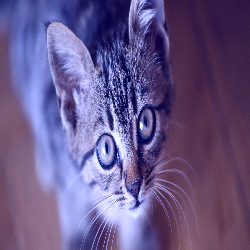

In [32]:
def gradCAM(orig, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_94')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.flatten()[:64]
  heatmap = heatmap[:64].reshape((8, 8))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

gradCAM("Chinook-On-White-03.jpg")
gradCAM("Thinking-of-getting-a-cat.png")